In [1]:
import tensorflow as tf
import numpy as np
import unicodedata
import re
import pandas as pd
import tensorflow.keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle 

In [2]:
conv = pd.read_csv("C:/Users/dell/Desktop/Practicum/Chatbot.csv",encoding= 'unicode_escape')
conv.head()
conv=shuffle(conv)

In [3]:
conv['Questions'] = conv['Questions'].astype(str)
conv['Answers'] = conv['Answers'].astype(str)

In [4]:
# clean up text

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

In [5]:
# clean up text
raw_data_en = [normalize_string(data) for data in conv["Questions"]]

# add special token <start>/<end> to indicate the beginning and end of a sentence
raw_data_fr_in = ['<start> ' + normalize_string(data) for data in conv["Answers"]]
raw_data_fr_out = [normalize_string(data) + ' <end>' for data in conv["Answers"]]

In [6]:
# Tokenize each sentence and index each word
max_en_words = 5000
max_en_len = 10
en_tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(filters='', \
                                                  num_words=max_en_words )
en_tokenizer.fit_on_texts(raw_data_en)
en_tokenizer.fit_on_texts(raw_data_fr_in)
en_tokenizer.fit_on_texts(raw_data_fr_out)

print("Total number of English words: ", len(en_tokenizer.word_index))

Total number of English words:  686


In [7]:
data_q = en_tokenizer.texts_to_sequences(raw_data_en)
data_q = tensorflow.keras.preprocessing.sequence.pad_sequences(data_q,\
                                                     maxlen=max_en_len, \
                                                     padding='post')

data_a_in = en_tokenizer.texts_to_sequences(raw_data_fr_in)
data_a_in = tensorflow.keras.preprocessing.sequence.pad_sequences(data_a_in,\
                                                     maxlen=max_en_len, \
                                                     padding='post')

data_a_out = en_tokenizer.texts_to_sequences(raw_data_fr_out)
data_a_out = tensorflow.keras.preprocessing.sequence.pad_sequences(data_a_out,\
                                                     maxlen=max_en_len, \
                                                     padding='post')

In [8]:
# Convert each word index using one-hot coding
# This variable is the target of training

data_a_out_cat = to_categorical(data_a_out, num_classes=max_en_words)
data_a_out_cat.shape

(51, 10, 5000)

In [9]:
latent_dim = 100

In [10]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(max_en_len,))

embed = Embedding(max_en_words, latent_dim, mask_zero = True, input_length=max_en_len)
encoder_embed = embed(encoder_inputs)

encoder_lstm = LSTM(latent_dim,return_state=True,\
                   dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h, state_c]

In [11]:
# Set up the decoder, using `encoder_states` as initial state.
# the shape of decoder_inputs is set to None so it can translate 
# with a single word input, not necessary a sentence input
decoder_inputs = Input(shape=(None,))

decoder_embed = embed(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,\
                   dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embed, initial_state=encoder_states)
decoder_dense = Dense(max_en_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [12]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             500000      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 80400       embedding[0][0]       

In [13]:
batch_size=5
epochs = 50


# Compile & run training
model.compile(optimizer='rmsprop', \
              loss='categorical_crossentropy',\
              metrics=['categorical_accuracy'])

history = model.fit([data_q, data_a_in],data_a_out_cat, batch_size=batch_size,\
                       verbose =2, epochs=epochs, \
                       validation_split=0.2)

Epoch 1/50
8/8 - 2s - loss: 8.1057 - categorical_accuracy: 0.0992 - val_loss: 7.9944 - val_categorical_accuracy: 0.1000
Epoch 2/50
8/8 - 1s - loss: 6.4610 - categorical_accuracy: 0.1044 - val_loss: 6.5702 - val_categorical_accuracy: 0.1000
Epoch 3/50
8/8 - 1s - loss: 5.1198 - categorical_accuracy: 0.1044 - val_loss: 6.5169 - val_categorical_accuracy: 0.1000
Epoch 4/50
8/8 - 1s - loss: 4.7719 - categorical_accuracy: 0.1044 - val_loss: 6.6000 - val_categorical_accuracy: 0.0818
Epoch 5/50
8/8 - 1s - loss: 4.6054 - categorical_accuracy: 0.1070 - val_loss: 6.7044 - val_categorical_accuracy: 0.0818
Epoch 6/50
8/8 - 1s - loss: 4.5083 - categorical_accuracy: 0.1018 - val_loss: 6.8024 - val_categorical_accuracy: 0.0818
Epoch 7/50
8/8 - 1s - loss: 4.4385 - categorical_accuracy: 0.1149 - val_loss: 6.9098 - val_categorical_accuracy: 0.0818
Epoch 8/50
8/8 - 1s - loss: 4.3889 - categorical_accuracy: 0.1097 - val_loss: 7.0325 - val_categorical_accuracy: 0.1000
Epoch 9/50
8/8 - 1s - loss: 4.3516 - cat

In [14]:
from tensorflow.keras.layers import Lambda, Dot, Activation, Concatenate, Dropout, Bidirectional
from tensorflow.keras import backend as K

max_en_words = 5000
max_en_len = 10
latent_dim = 100

# Define an input sequence and process it.
encoder_inputs = Input(shape=(max_en_len,))

embed = Embedding(max_en_words, latent_dim, mask_zero = True, input_length=max_en_len)
encoder_embed = embed(encoder_inputs)

encoder_lstm = Bidirectional(LSTM(latent_dim,return_sequences=True, \
                    dropout = 0.2, recurrent_dropout =0.2,\
                    return_state=True))

encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embed)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# the shape of decoder_inputs is set to None so it can translate 
# with a single word input, not necessary a sentence input
decoder_inputs = Input(shape=(None,))

decoder_embed = embed(decoder_inputs)

decoder_lstm = LSTM(200, return_sequences=True, return_state=True, \
                   dropout = 0.2, recurrent_dropout =0.2)

decoder_outputs, _, _ = decoder_lstm(decoder_embed, initial_state=encoder_states)


# Transform encoder outputs to a space which can be aligned with decoder output
encoder_outputs_transformed = Dense(200, \
                                    activation=None, \
                                    use_bias=False)(encoder_outputs)

# Calculate alignment between decoder and encoder
attention = Dot(axes = [2,2])([decoder_outputs, encoder_outputs_transformed])
attention = Activation('tanh')(attention)


# Normalize alignment score
attention = Activation('softmax')(attention)

# Weighted sum
context = Dot(axes=[2,1]) ([attention, encoder_outputs])

# Concatenate context with decoder output
decoder_combined_context = Concatenate(axis = -1)([context, decoder_outputs])

decoder_dense = Dense(max_en_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             500000      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 10, 200), (N 160800      embedding_1[0][0]     

In [15]:
# Compile & run training
batch_size=5
epochs = 50

model2.compile(optimizer='rmsprop', \
              loss='categorical_crossentropy',\
              metrics=['categorical_accuracy'])

history2 = model2.fit([data_q, data_a_in],data_a_out_cat, batch_size=batch_size,\
                       verbose =2, epochs=epochs, \
                       validation_split=0.2)

Epoch 1/50
8/8 - 3s - loss: 7.9323 - categorical_accuracy: 0.1097 - val_loss: 6.8428 - val_categorical_accuracy: 0.0818
Epoch 2/50
8/8 - 1s - loss: 5.5693 - categorical_accuracy: 0.1097 - val_loss: 6.6699 - val_categorical_accuracy: 0.1091
Epoch 3/50
8/8 - 1s - loss: 4.7750 - categorical_accuracy: 0.1253 - val_loss: 6.9426 - val_categorical_accuracy: 0.0909
Epoch 4/50
8/8 - 1s - loss: 4.4669 - categorical_accuracy: 0.1305 - val_loss: 7.1856 - val_categorical_accuracy: 0.0909
Epoch 5/50
8/8 - 1s - loss: 4.3384 - categorical_accuracy: 0.1149 - val_loss: 7.4015 - val_categorical_accuracy: 0.1091
Epoch 6/50
8/8 - 1s - loss: 4.2323 - categorical_accuracy: 0.1305 - val_loss: 7.5099 - val_categorical_accuracy: 0.1364
Epoch 7/50
8/8 - 1s - loss: 4.1445 - categorical_accuracy: 0.1462 - val_loss: 7.7097 - val_categorical_accuracy: 0.1091
Epoch 8/50
8/8 - 1s - loss: 4.0677 - categorical_accuracy: 0.1593 - val_loss: 7.8102 - val_categorical_accuracy: 0.1273
Epoch 9/50
8/8 - 1s - loss: 4.0035 - cat

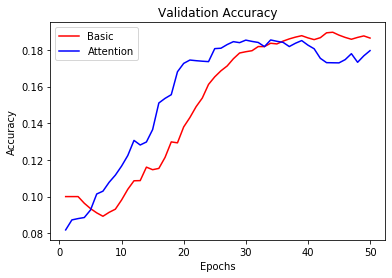

In [17]:
import matplotlib.pyplot as plt

# Compare the result
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

epochs = range(1, len(history.history['val_categorical_accuracy']) + 1)
plt.plot(epochs, smooth_curve(history.history['val_categorical_accuracy']), 'r-', label='Basic')
plt.plot(epochs, smooth_curve(history2.history['val_categorical_accuracy']), 'b-', label='Attention')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()